In [2]:
# Import libraries
import pandas as pd
pd.plotting.register_matplotlib_converters()
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import re
from datetime import datetime
from sklearn.ensemble import IsolationForest
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
#from fbprophet import Prophet
#from pmdarima import auto_arima
from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")
import calendar
import pickle

In [3]:
# Read data
df = pd.read_csv(r'/content/train_1.csv')
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [4]:
# Fill missing values
df = df.fillna(0)

In [5]:
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [6]:
df.dtypes

,0
Page,object
2015-07-01,float64
2015-07-02,float64
2015-07-03,float64
2015-07-04,float64
...,...
2016-12-27,float64
2016-12-28,float64
2016-12-29,float64
2016-12-30,float64


In [7]:
# Reshaping the dataframe
df_reshaped = pd.melt(df,id_vars=['Page'],var_name='Date',value_name='Views')
df_reshaped.head()

,Page,Date,Views
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11.0
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1.0
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-01,0.0


In [8]:
# Setting 'Date' column as the index
df_reshaped['Date'] = pd.DatetimeIndex(df_reshaped['Date'])
df_reshaped = df_reshaped.set_index('Date')
df_reshaped.head()

,Page,Views
Date,,
2015-07-01,2NE1_zh.wikipedia.org_all-access_spider,18.0
2015-07-01,2PM_zh.wikipedia.org_all-access_spider,11.0
2015-07-01,3C_zh.wikipedia.org_all-access_spider,1.0
2015-07-01,4minute_zh.wikipedia.org_all-access_spider,35.0
2015-07-01,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0


In [9]:
df_reshaped.dtypes

,0
Page,object
Views,float64


## Time series analysis


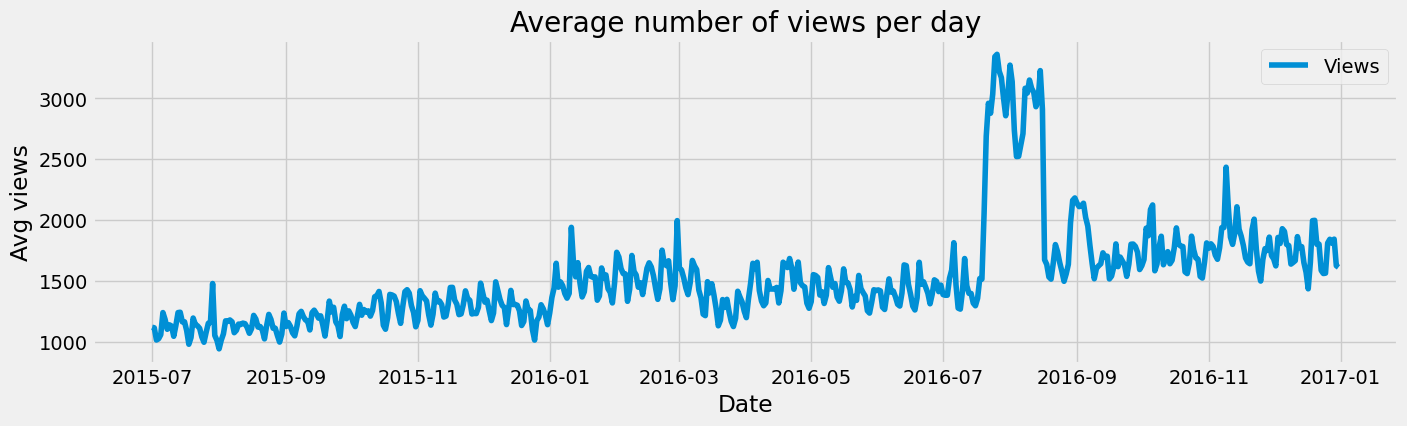

In [10]:
# Average number of views per day
temp = df_reshaped.groupby('Date')['Views'].mean()
plt.figure(figsize=(15,4))
plt.xlabel('Date')
plt.ylabel('Avg views')
plt.title('Average number of views per day')
plt.plot(temp,label='Views')
plt.legend()
plt.show()

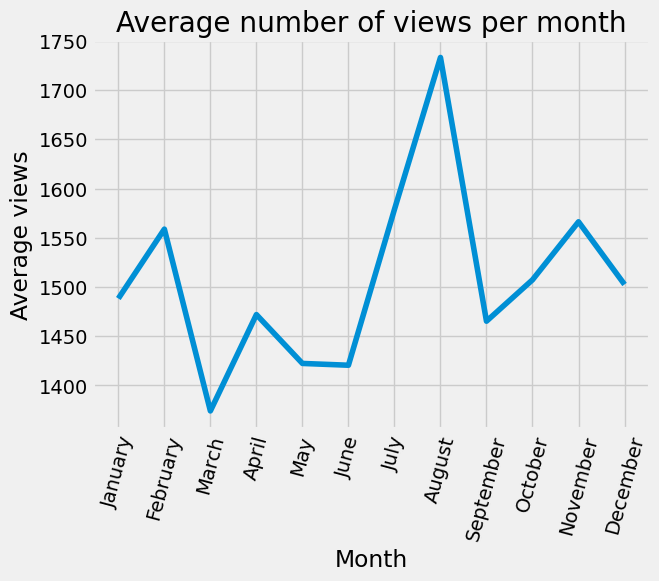

In [12]:
# Average number of views per month
month_index = df_reshaped.index.month
views_by_month = df_reshaped.groupby(month_index)['Views'].mean()
months=['January','February','March','April','May','June','July','August','September','October','November','December']
ax = views_by_month.plot()

# Setting the xticks explicitly to match the number of months (1 to 12)
ax.set_xticks(range(1, len(months) + 1))

# Setting the xtick labels with the months list
ax.set_xticklabels(months,rotation=75)

ax.set_xlabel('Month')
ax.set_ylabel('Average views')
ax.set_title('Average number of views per month')
plt.show()

In [13]:
def detect_lang(page):
    text = page.split('.wikipedia')
    if re.search('[a-z][a-z]',text[0][-2:]):
        return text[0][-2:]
    else:
        return 'none'
temp1 = df_reshaped
temp1['Wikipedia_page'] = temp1.Page.apply(detect_lang)

def lang_code(code):
    if code == 'zh':
        return 'Chinese'
    elif code == 'fr':
        return 'French'
    elif code == 'en':
        return 'English'
    elif code == 'ru':
        return 'Russian'
    elif code == 'de':
        return 'German'
    elif code == 'ja':
        return 'Japanese'
    elif code == 'es':
        return 'Spanish'
    else:
        return 'None'

temp1['Page_language'] = temp1.Wikipedia_page.apply(lang_code)

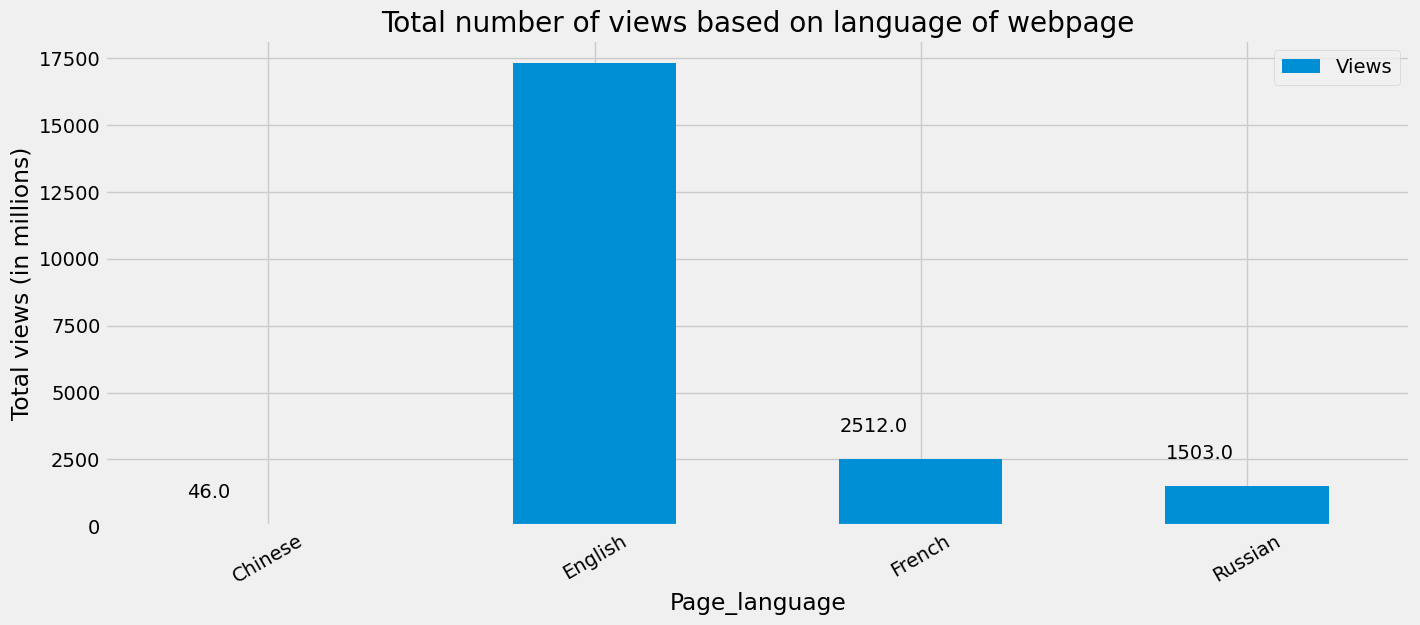

In [14]:
# Total number of views based on language of Wikipedia webpage
fig,ax = plt.subplots(figsize=(15,6))
lang_df = temp1.groupby('Page_language')['Views'].sum().reset_index()
lang_df = lang_df[lang_df['Page_language']!='None']
lang_df['Views'] = round(lang_df['Views']/1000000,0)

bar_graph = lang_df.plot.bar(x='Page_language',y='Views',rot=30,ax=ax)
bar_graph.set_ylabel('Total views (in millions)')
bar_graph.set_title('Total number of views based on language of webpage')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x(), p.get_height()+1000))
ax.legend()
plt.show()

In [15]:
# Extracting day of week from date
days_df = df_reshaped.copy()
days_df = days_df[['Page','Views']]
days_df['Dayofweek'] = days_df.index.dayofweek

In [16]:
def find_day(day):
    if day == 0:
        return 'Monday'
    elif day == 1:
        return 'Tuesday'
    elif day == 2:
        return 'Wednesday'
    elif day == 3:
        return 'Thursday'
    elif day == 4:
        return 'Friday'
    elif day == 5:
        return 'Saturday'
    else:
        return 'Sunday'

days_df['Day'] = days_df.Dayofweek.apply(find_day)

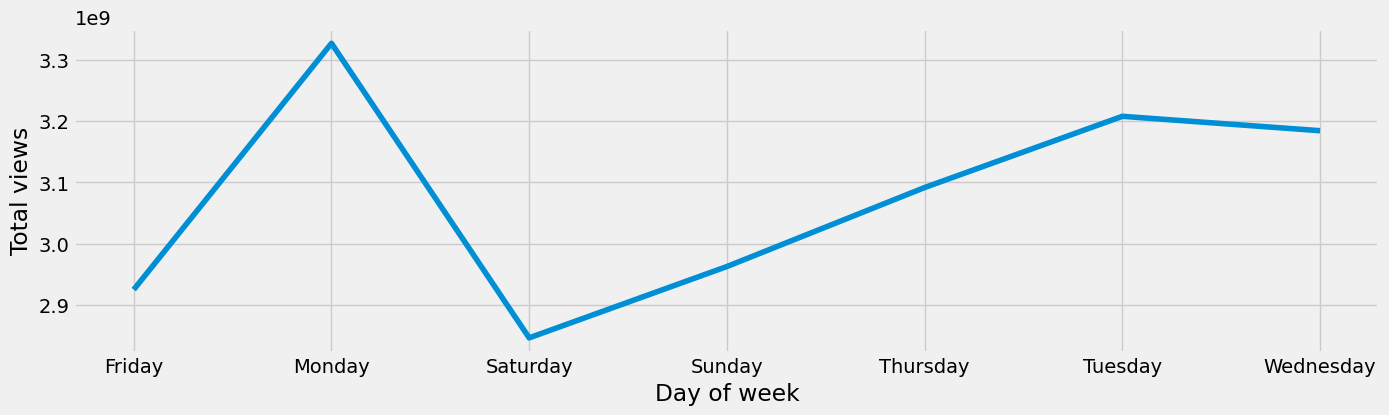

In [17]:
day = days_df.groupby('Day')['Views'].sum()
plt.figure(figsize=(15,4))
plt.xlabel('Day of week')
plt.ylabel('Total views')
plt.plot(day)
plt.show()

In [18]:
# Top 5 pages with maximum number of views
top_pages = df_reshaped.groupby('Page')['Views'].sum().reset_index()
top_pages_list = top_pages.nlargest(5,'Views')['Page'].tolist()

In [19]:
top5_pages_df = df_reshaped[df_reshaped['Page'].isin(top_pages_list)]

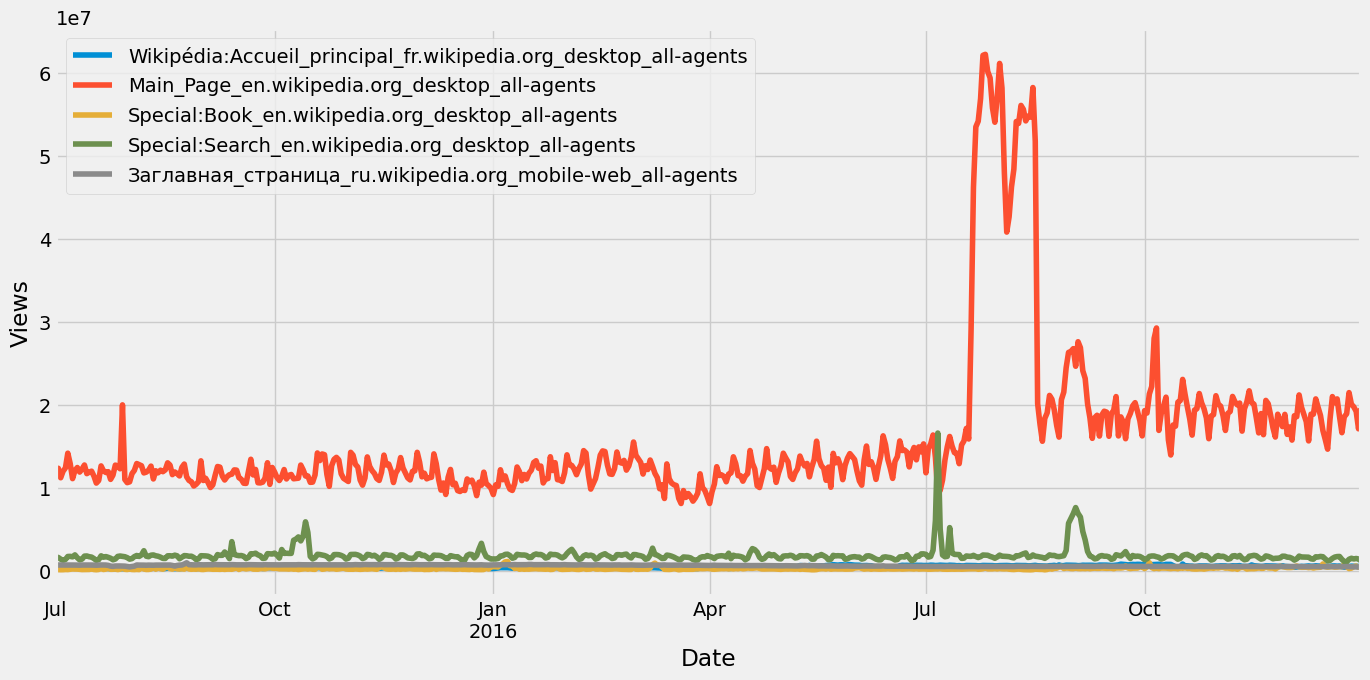

In [20]:
# Plot with top 5 pages which have maximum number of views
fig, ax = plt.subplots(figsize=(15,7))
for i in list(top5_pages_df.Page.unique())[:5]:
    top5_pages_df.loc[top5_pages_df.Page == i].plot(ax=ax)

ax.set_ylabel('Views')
ax.legend(list(top5_pages_df.Page.unique())[:5],loc='upper left')
plt.show()

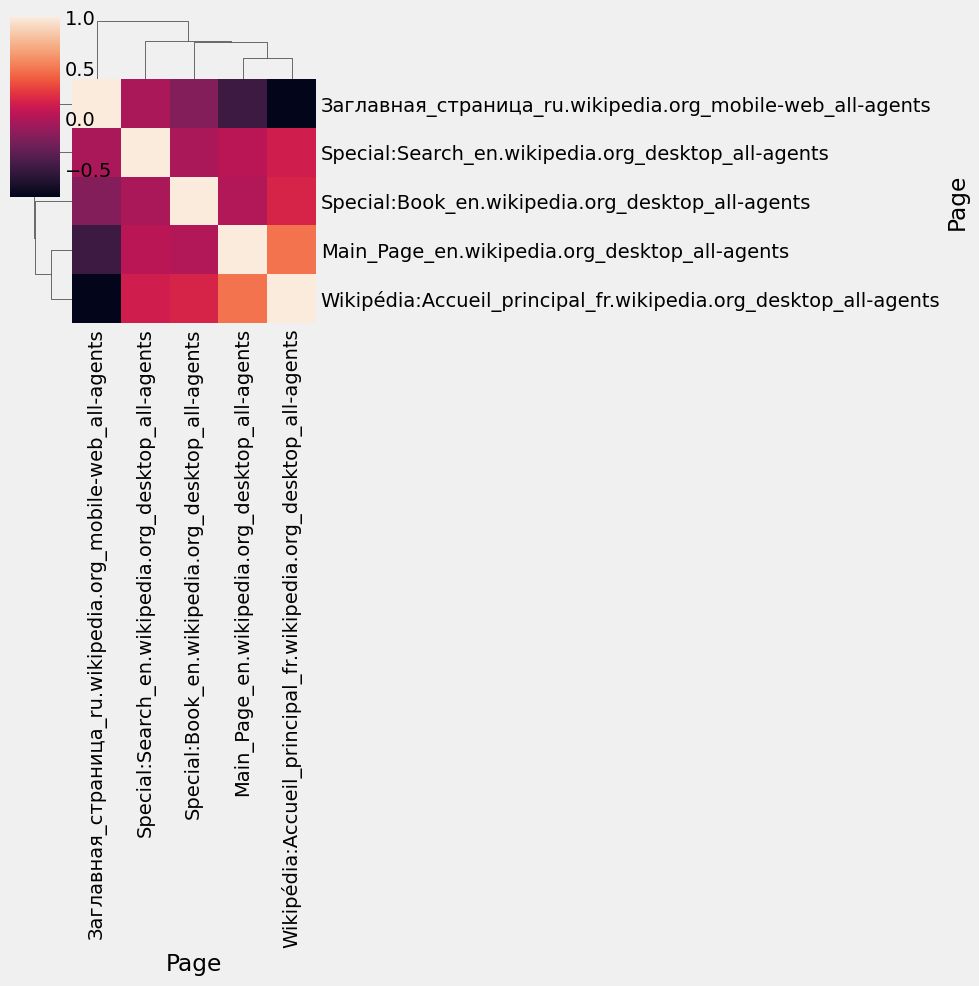

In [21]:
# Correlation between pages
table = pd.pivot_table(top5_pages_df,values='Views',index=['Date'],columns=['Page'])
corr_matrix = table.corr(method='pearson')
sns.clustermap(corr_matrix)

In [22]:
# Time-series of page with maximum views
top_page_df = df_reshaped[df_reshaped.Page == top_pages_list[0]]
top_page_df = top_page_df[['Views']]
top_page_df['Views'] = top_page_df['Views'].div(1000000).round(2)
top_page_df.head()

,Views
Date,
2015-07-01,11.95
2015-07-02,12.34
2015-07-03,11.20
2015-07-04,11.98
2015-07-05,12.38


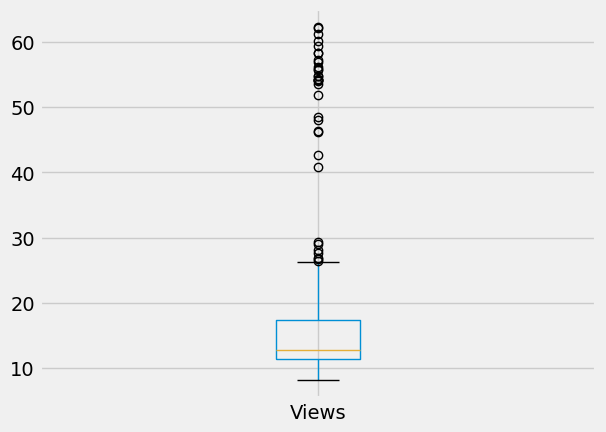

In [23]:
ax1 = top_page_df.boxplot()

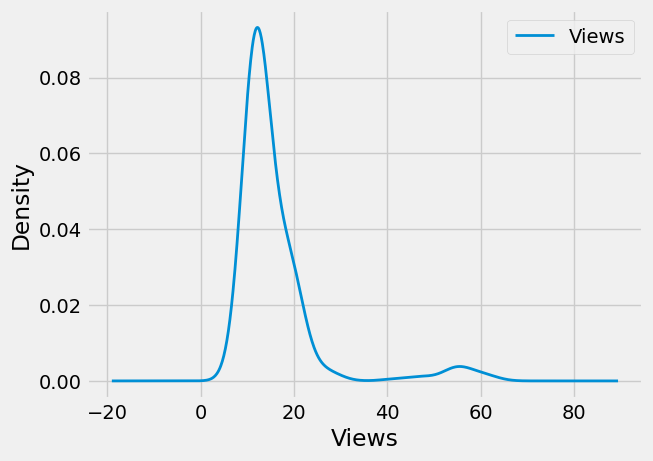

In [24]:
ax2 = top_page_df.plot(kind='density', linewidth=2)
ax2.set_xlabel('Views')
plt.show()

<Axes: xlabel='Date'>

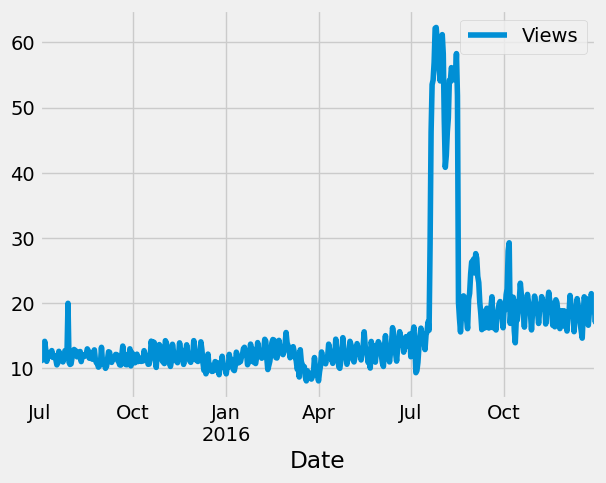

In [25]:
top_page_df.plot()

- The above data will be used in the time-series forecasting models.
- As seen in the figure above, there are anomalies in the data. Using data with anomalies for forecasting will affect the accuracy of the model. Hence, the anomalies are removed using Isolation Forest.

## Anomaly detection using Isolation Forest


In [26]:
isolation_forest_model = IsolationForest(contamination=0.08)
isolation_forest_model.fit(top_page_df)
top_page_df['anomaly'] = isolation_forest_model.predict(top_page_df)

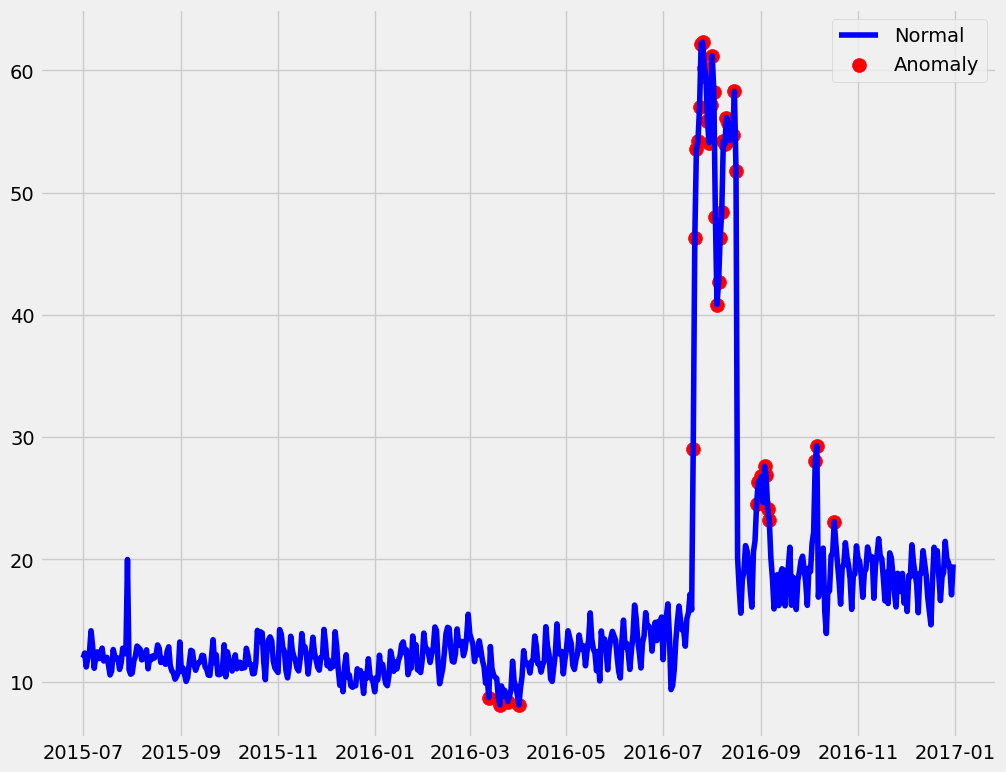

In [27]:
fig, ax = plt.subplots(figsize=(11,9))
anomaly_df = top_page_df.loc[top_page_df['anomaly'] == -1].copy()
ax.plot(top_page_df.index,top_page_df['Views'],color='blue', label = 'Normal')
plt.scatter(anomaly_df.index,anomaly_df['Views'],color='red',s=100,label = 'Anomaly')
plt.legend()
plt.show()

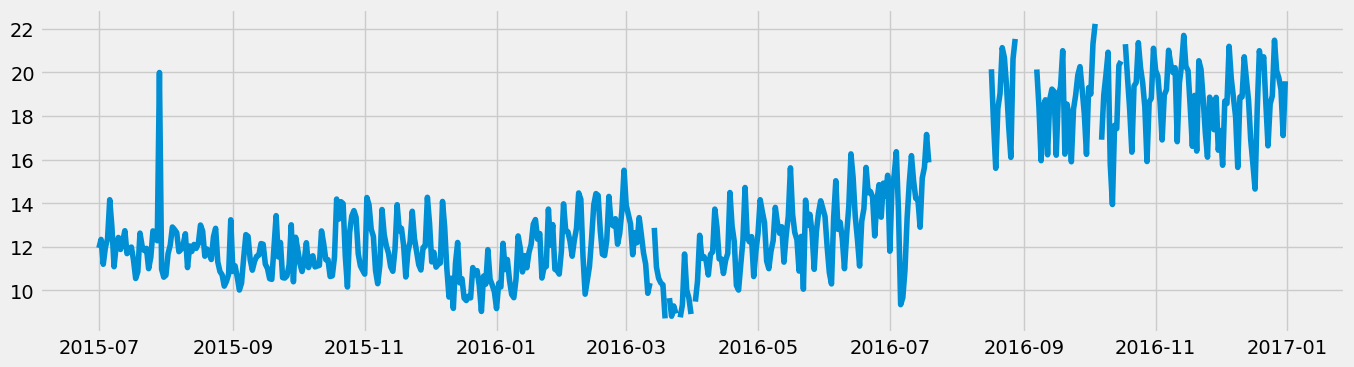

In [28]:
# Removing anomalies from the data
top_page_df['new_views'] = top_page_df.apply(lambda row: row.Views if row.anomaly == 1 else None, axis='columns')
plt.figure(figsize=(15,4))
plt.plot(top_page_df.index,top_page_df.new_views)

- Removing anomalies in the data creates some missing values.
- The missing values are filled with rolling mean or moving average of 30 days.

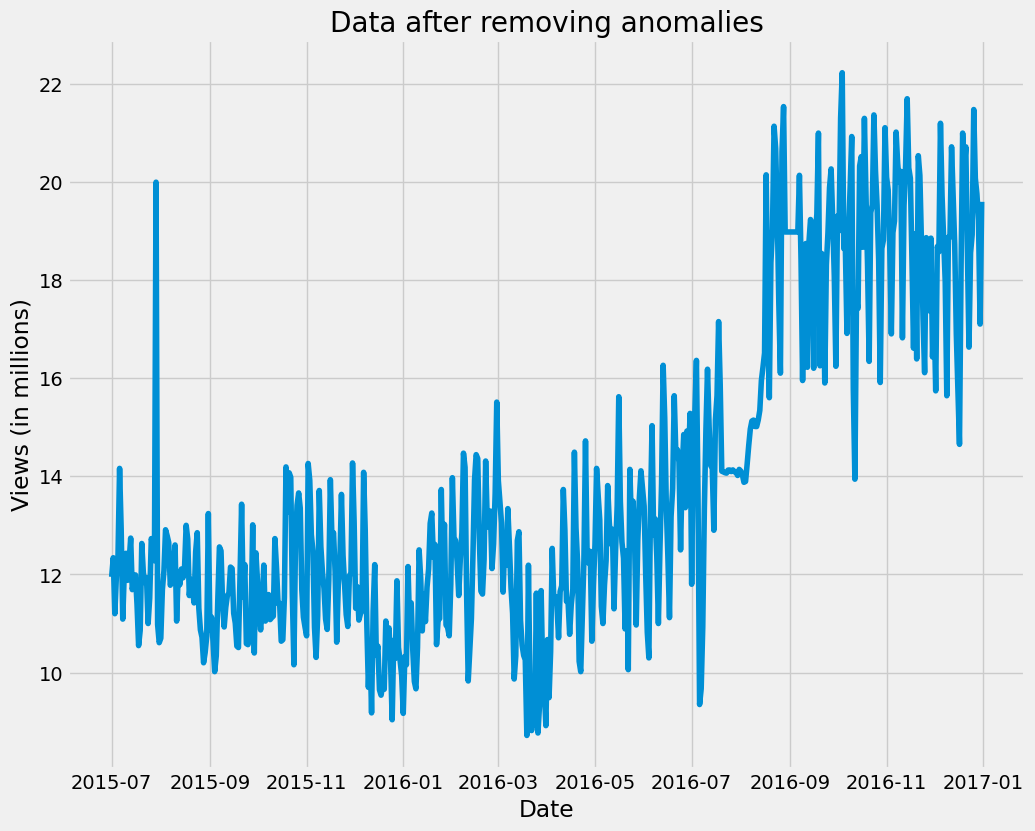

In [29]:
# Filling missing data with rolling mean
top_page_df = top_page_df.assign(rolling_mean=top_page_df.new_views.fillna(top_page_df.new_views.rolling(30,min_periods=1).mean()))

plt.figure(figsize=(11,9))
plt.plot(top_page_df.index,top_page_df.rolling_mean)
plt.title('Data after removing anomalies')
plt.xlabel('Date')
plt.ylabel('Views (in millions)')
plt.show()

In [30]:
top_page_df = top_page_df.drop(columns=['Views','anomaly','new_views']).rename(columns={'rolling_mean':'Views'})

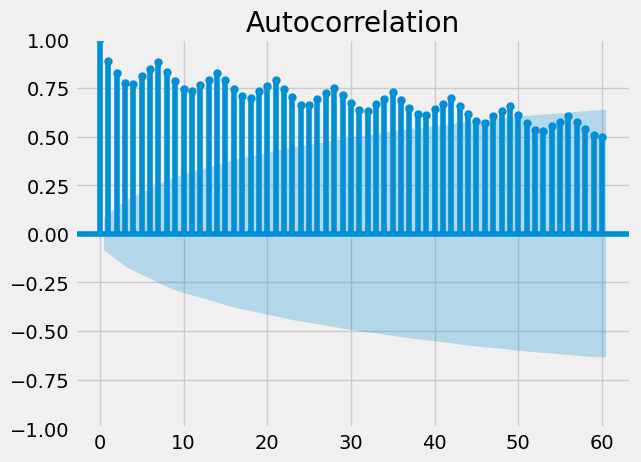

In [31]:
fig = tsaplots.plot_acf(top_page_df['Views'], lags=60)
plt.show()

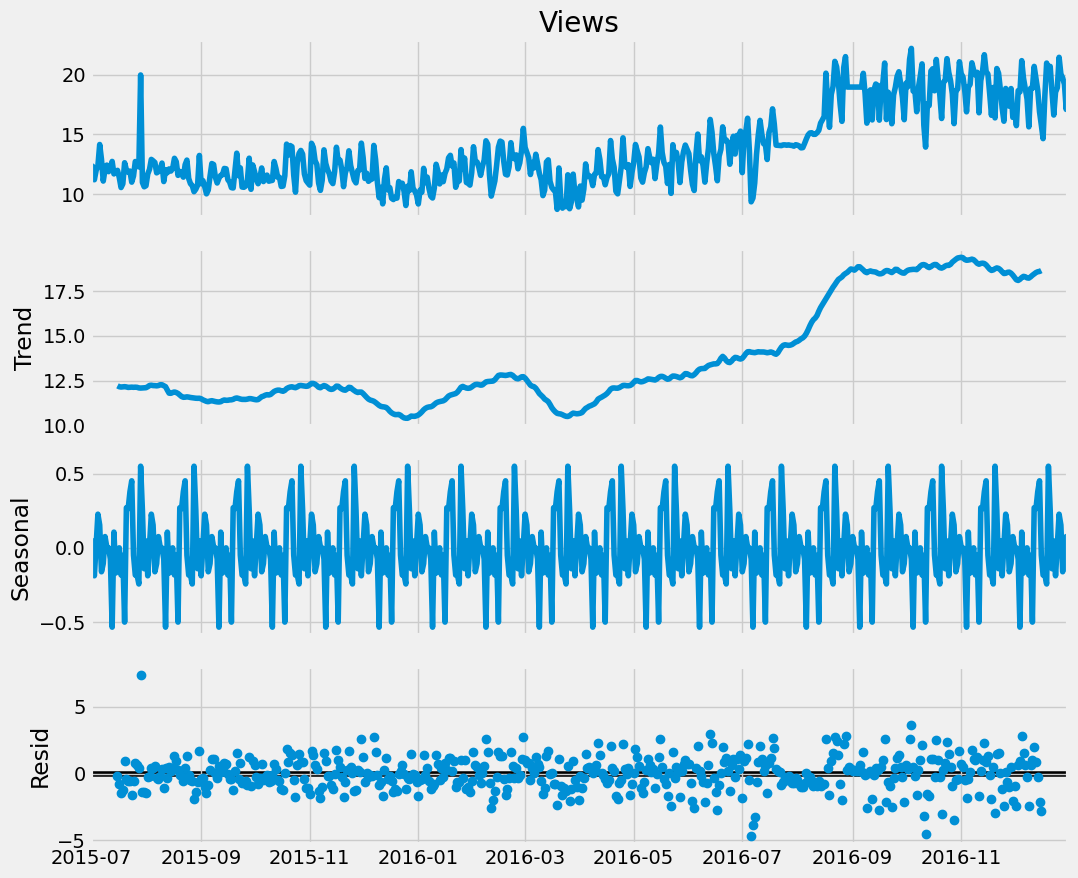

In [32]:
rcParams['figure.figsize'] = 11,9
ts_decomposition = sm.tsa.seasonal_decompose(top_page_df.Views,period = 30)
figure = ts_decomposition.plot()

### Augmented Dicky-Fuller test

In [33]:
test = adfuller(top_page_df['Views'])
print(test)

(-0.32345724178275975, 0.9221157543437549, 14, 535, {'1%': -3.4426321555520905, '5%': -2.86695748394138, '10%': -2.5696553279762426}, 1668.6900729007955)


 - First element is the test statistic. Test statistic shows how likely the data is stationary.
 - Second element indicates the p-value. Since the p-value is not < 0.05, we cannot reject null hypothesis. The null hypothesis is that data is not stationary. Therefore, data is not stationary.

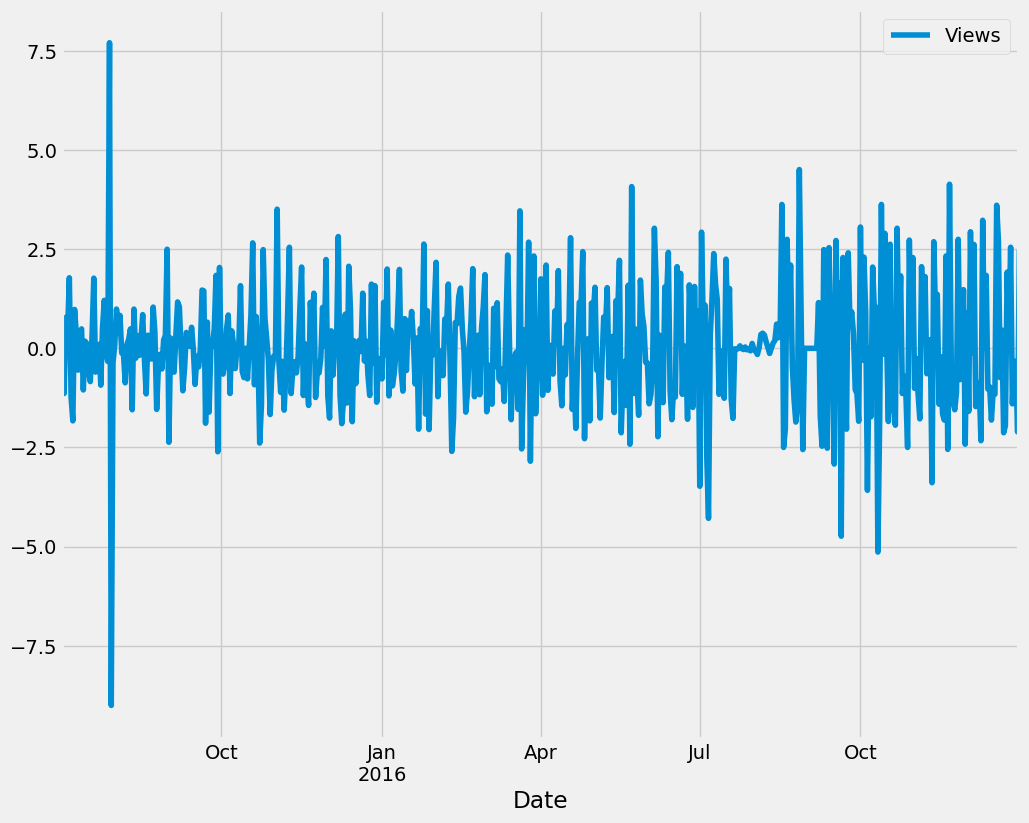

In [34]:
# Differencing the data to make it stationary
top_page_stationary_df = top_page_df.diff().dropna()
ax = top_page_stationary_df.plot()

In [35]:
# Augmented dicky-fuller test on stationary data
test2 = adfuller(top_page_stationary_df['Views'])
print(test2)

(-6.999559177868646, 7.382057574773097e-10, 19, 529, {'1%': -3.442772146350605, '5%': -2.8670191055991836, '10%': -2.5696881663873414}, 1663.3564841625314)


- We can see that the test statistic is more for stationary data. This means that the data is now more likely to be stationary.
- Since the p-value(second element) is less than 0.05, null hypothesis can be rejected. Therefore, data is stationary.

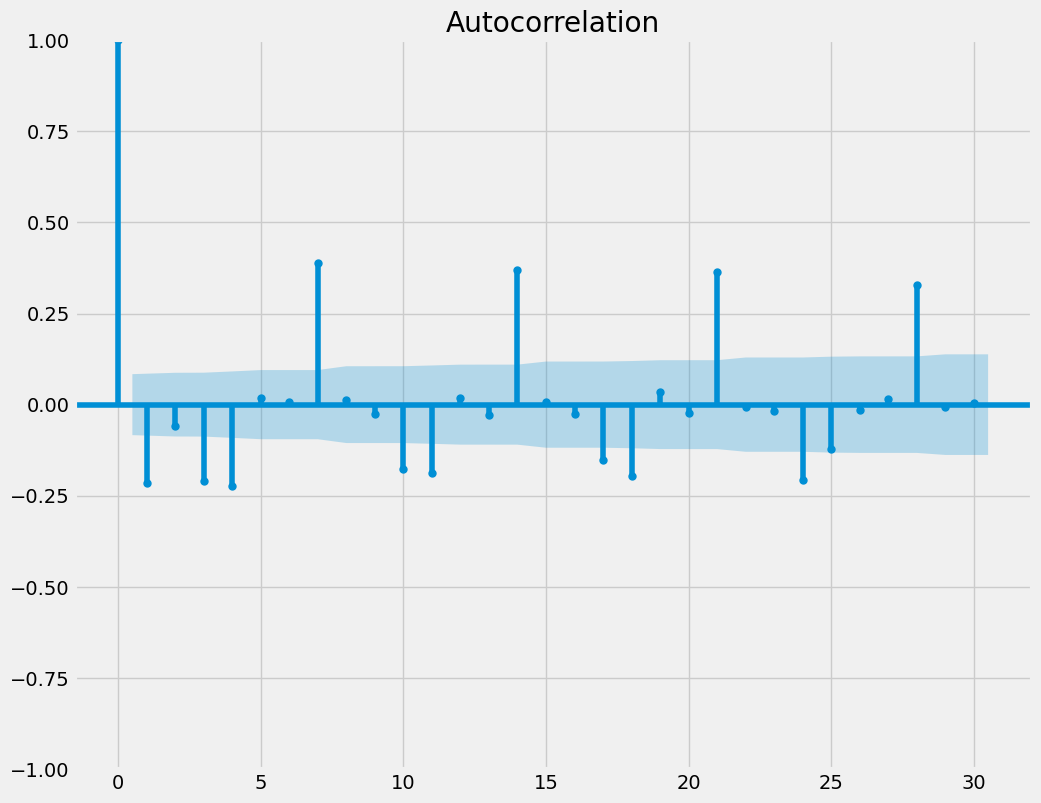

In [36]:
fig = tsaplots.plot_acf(top_page_stationary_df['Views'], lags=30)
plt.show()

## Preparing the data for modeling

In [37]:
train = top_page_df[:'2016-09']
test = top_page_df['2016-10':]

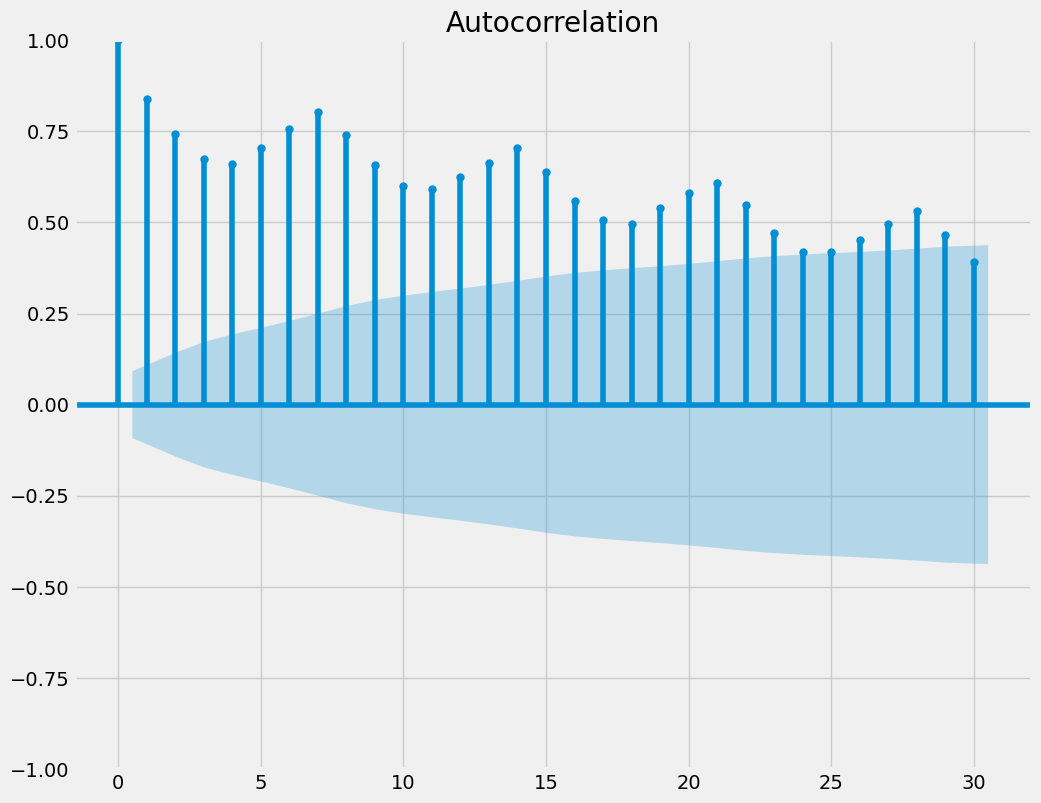

In [38]:
fig = tsaplots.plot_acf(train['Views'], lags=30)
plt.show()

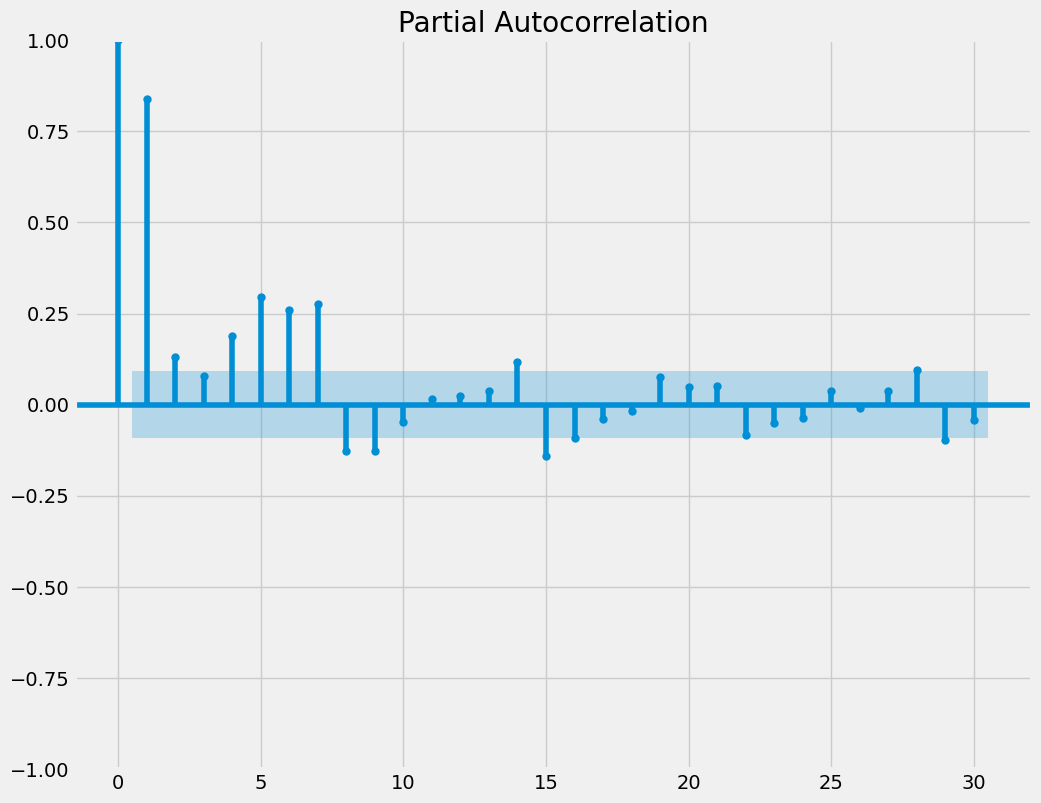

In [39]:
fig = tsaplots.plot_pacf(train['Views'], lags=30)
plt.show()

## ARMA model


In [40]:
aic_bic_values = []
for p in range(7):
    for q in range(7):
        try:
            model = SARIMAX(train, order=(p,0,q))
            result = model.fit()
            aic_bic_values.append((p,q,result.aic,result.bic))
        except:
            continue

In [41]:
aic_bic_df = pd.DataFrame(aic_bic_values,columns=['p','q','aic','bic'])
aic_bic_df = aic_bic_df.sort_values(by=['aic','bic'])

### Prediction using ARMA


In [42]:
model = SARIMAX(train,order=(int(aic_bic_df.iloc[0]['p']),0,int(aic_bic_df.iloc[0]['q'])))
result = model.fit()

In [43]:
with open('arma_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [44]:
forecast = result.get_prediction(start=-30)
forecast_mean = forecast.predicted_mean
confidence_interval = forecast.conf_int()

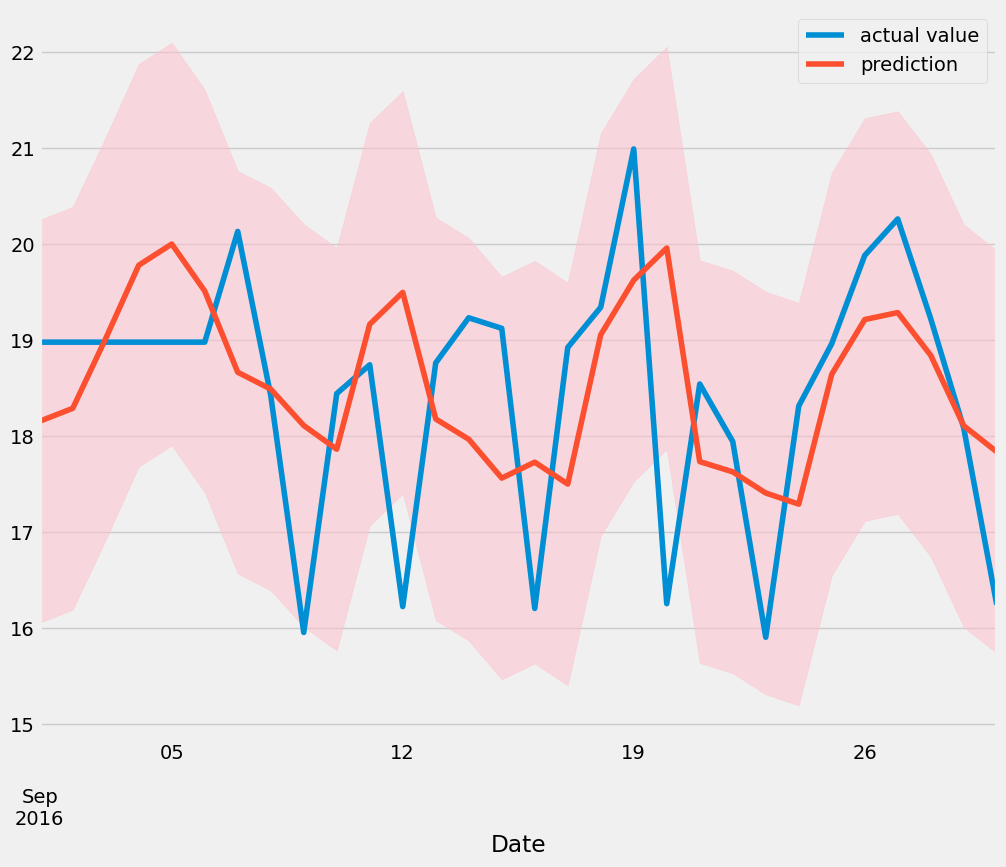

In [45]:
fig,ax=plt.subplots()
train[-30:].rename(columns={'Views':'actual value'}).plot(ax=ax)
forecast_mean.plot(ax=ax,label='prediction')
plt.fill_between(confidence_interval.index, \
                confidence_interval['lower Views'], \
                confidence_interval['upper Views'], \
                color='pink', alpha=0.5)
plt.legend()
plt.show()

### Forecasting using ARMA model


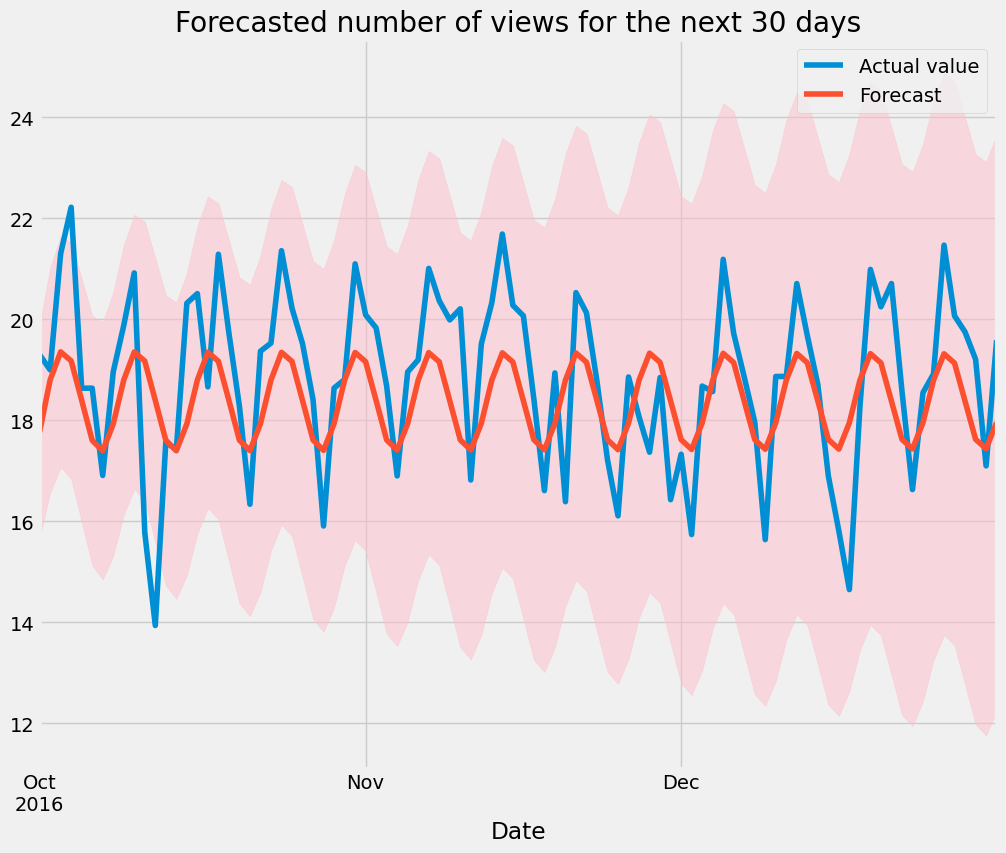

In [46]:
forecast_values = result.get_forecast(steps=test.shape[0])
forecast_values_mean = forecast_values.predicted_mean
conf_interval = forecast_values.conf_int()

arma_forecast_df = pd.DataFrame({'Date':test.index,'Views':forecast_values.predicted_mean,'lower_views':conf_interval['lower Views'].values,'upper_views':conf_interval['upper Views'].values})
arma_forecast_df = arma_forecast_df.set_index('Date')

fig,ax=plt.subplots()
test.rename(columns={'Views':'Actual value'}).plot(ax=ax)
arma_forecast_df[['Views']].rename(columns={'Views':'Forecast'}).plot(ax=ax,label='Forecast')
plt.fill_between(arma_forecast_df.index, \
                arma_forecast_df.lower_views, \
                arma_forecast_df.upper_views, \
                color='pink', alpha=0.5)
plt.title('Forecasted number of views for the next 30 days')
plt.legend()
plt.show()

In [47]:
rmse_values = []
rmse_values.append(('ARMA',np.sqrt(np.mean(np.square(forecast_values_mean.values - test.Views.values)))))

## ARIMA model


In [48]:
arima_aic_bic = []
for p in range(7):
    for q in range(7):
        try:
            arima_model = SARIMAX(train, order=(p,1,q))
            arima_result = arima_model.fit()
            arima_aic_bic.append((p,q,arima_result.aic,arima_result.bic))
        except:
            continue

arima_aic_bic_df = pd.DataFrame(arima_aic_bic,columns=['p','q','aic','bic'])
arima_aic_bic_df = arima_aic_bic_df.sort_values(by=['aic','bic'])

### Prediction using ARIMA

In [49]:
arima_model = SARIMAX(train,order=(int(aic_bic_df.iloc[0]['p']),1,int(aic_bic_df.iloc[0]['q'])))
arima_result = arima_model.fit()
arima_forecast_mean = arima_result.get_prediction(steps=-30).predicted_mean

In [50]:
with open('arima_model.pkl', 'wb') as f:
    pickle.dump(arima_model, f)

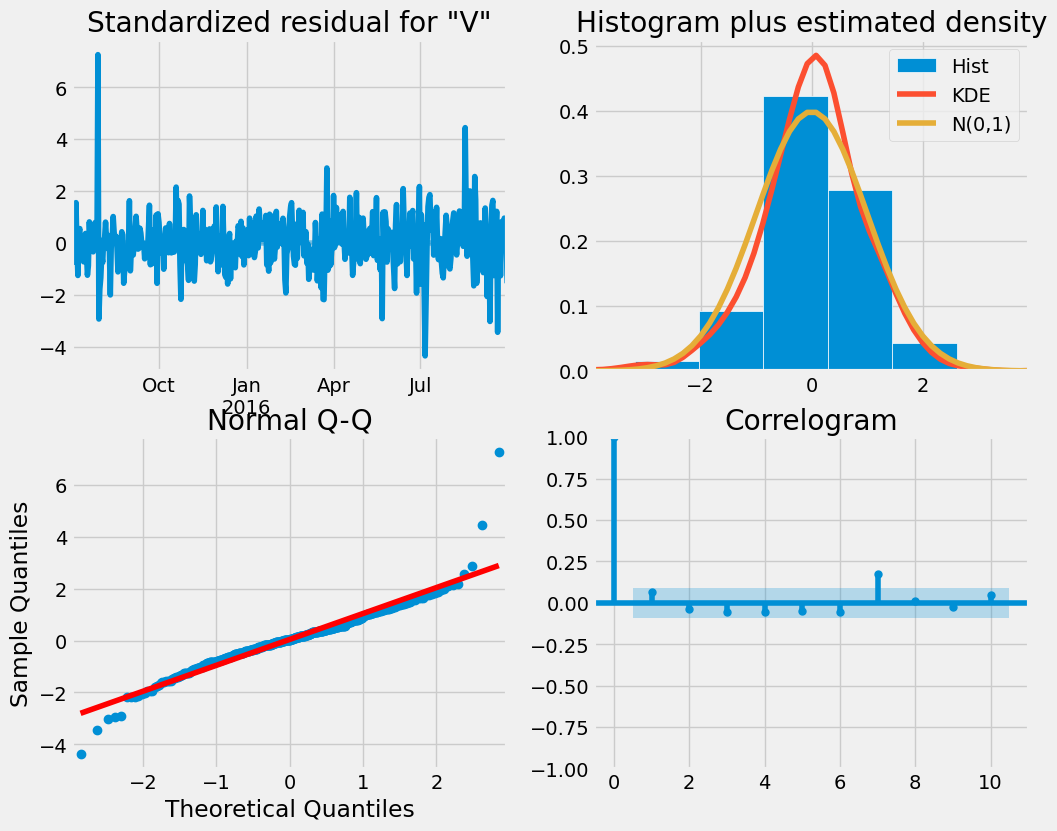

In [51]:
arima_result.plot_diagnostics()
plt.show()

In [52]:
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Views   No. Observations:                  458
Model:               SARIMAX(3, 1, 4)   Log Likelihood                -682.085
Date:                Mon, 06 Jan 2025   AIC                           1380.171
Time:                        15:12:19   BIC                           1413.168
Sample:                    07-01-2015   HQIC                          1393.168
                         - 09-30-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2653      0.029      9.241      0.000       0.209       0.322
ar.L2          0.2226      0.036      6.270      0.000       0.153       0.292
ar.L3         -0.9803      0.029    -34.307      0.000      -1.036      -0.924
ma.L1         -0.9730      0.043    -22.844      0.000      -1.056      -0.890
ma.L2         -0.0666      0.053     -1.265      0.206      -0.170       0.037
ma.L3          1.1689      0.053     22.159      0.000       1.066       1.272
ma.L4         -0.6985      0.037    -18.675      0.000      -0.772      -0.625
sigma2         1.1366      0.049     22.970      0.000       1.040       1.234
===================================================================================
Ljung-Box (L1) (Q):                   1.92   Jarque-Bera (JB):               990.19
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               1.42   Skew:                             0.58
Prob(H) (two-sided):                  0.03   Kurtosis:                        10.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

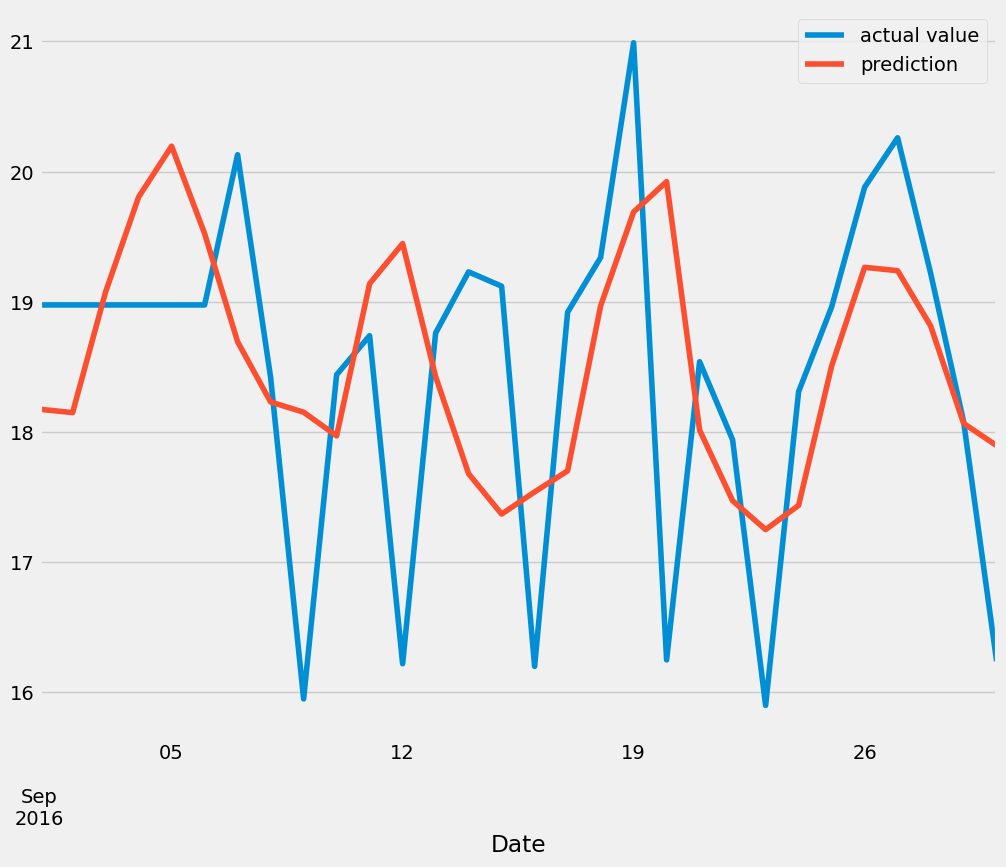

In [53]:
fig,ax=plt.subplots()
train[-30:].rename(columns={'Views':'actual value'}).plot(ax=ax)
arima_forecast_mean[-30:].plot(ax=ax,label='prediction')
plt.legend()
plt.show()

### Forecasting using ARIMA model

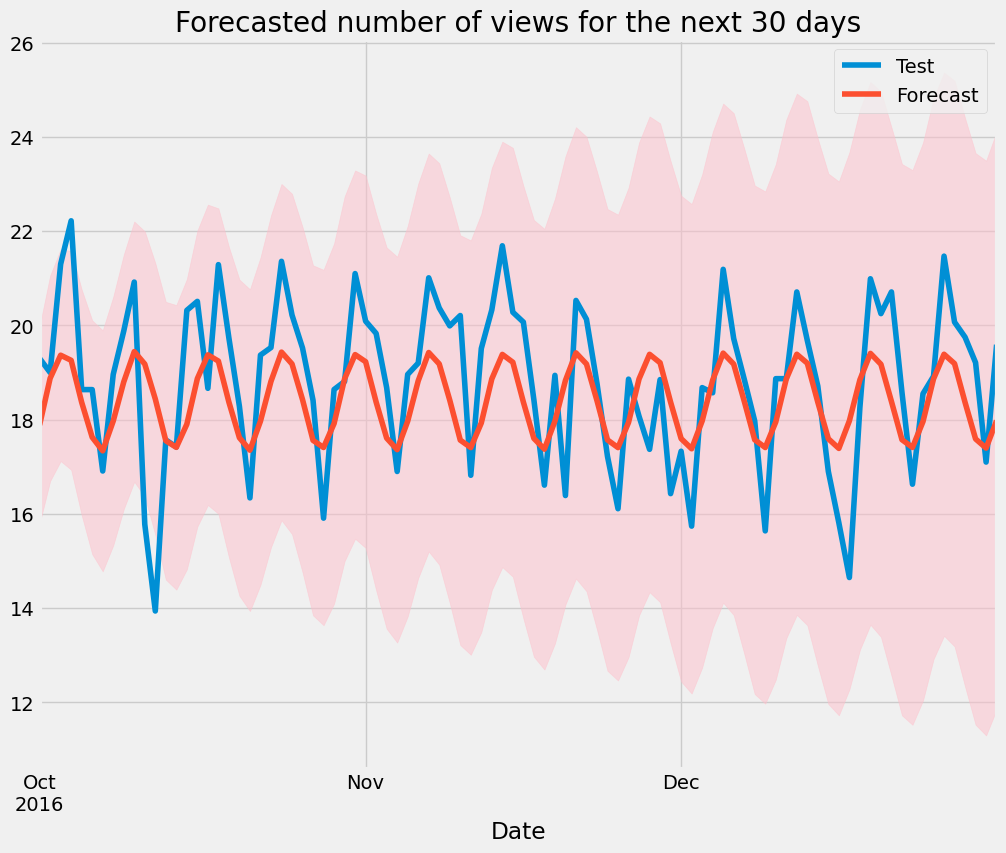

In [54]:
arima_forecast_values = arima_result.get_forecast(steps=test.shape[0])
arima_forecast_mean = arima_forecast_values.predicted_mean
arima_conf_interval = arima_forecast_values.conf_int()

arima_forecast_df = pd.DataFrame({'Date':test.index,'Views':arima_forecast_values.predicted_mean,'lower_views':arima_conf_interval['lower Views'].values,'upper_views':arima_conf_interval['upper Views'].values})
arima_forecast_df = arima_forecast_df.set_index('Date')

fig,ax=plt.subplots()
test.rename(columns={'Views':'Test'}).plot(ax=ax)
arima_forecast_df[['Views']].rename(columns={'Views':'Forecast'}).plot(ax=ax)
plt.fill_between(arima_forecast_df.index, \
                arima_forecast_df.lower_views, \
                arima_forecast_df.upper_views, \
                color='pink', alpha=0.5)
plt.title('Forecasted number of views for the next 30 days')
plt.legend()
plt.show()

In [55]:
rmse_values.append(('ARIMA',np.sqrt(np.mean(np.square(arima_forecast_df.Views.values - test.Views.values)))))

## Exponential smoothing model

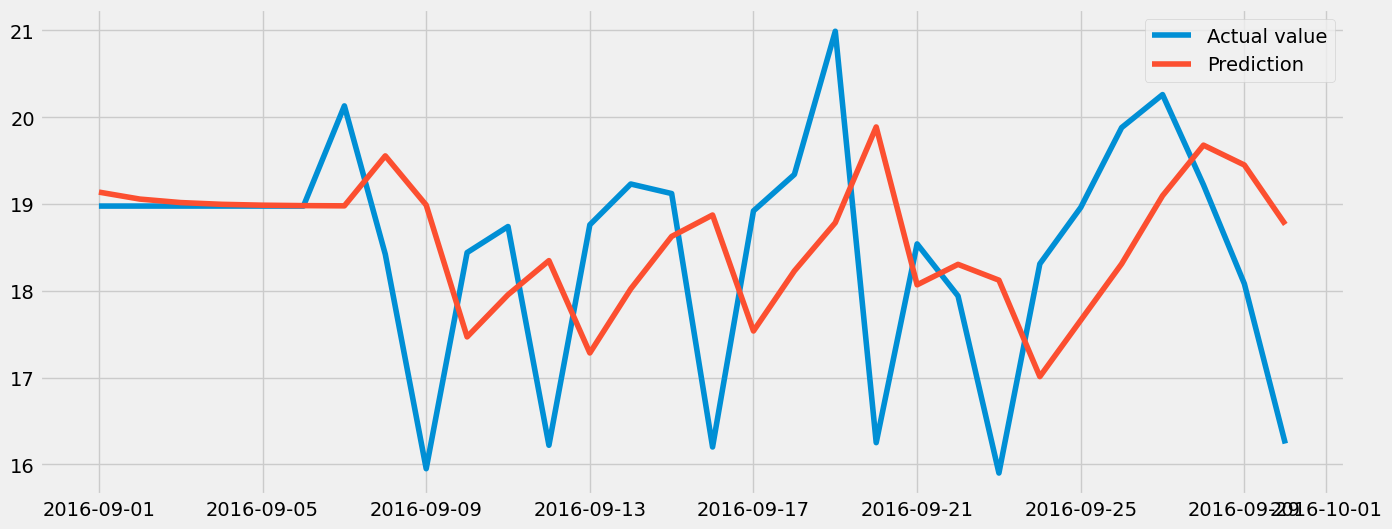

In [56]:
exp_smoothing_model = SimpleExpSmoothing(train)
exp_smoothing_result = exp_smoothing_model.fit(smoothing_level=0.5,optimized=True)

# Prediction using Exponential Smoothing model
exp_smoothing_prediction = exp_smoothing_result.predict(start=train[-30:-29].index[0],end=train[-1:].index[0])

plt.figure(figsize=(15,6))
plt.plot(train[-30:], label='Actual value')
plt.plot(exp_smoothing_prediction, label='Prediction')
plt.legend(loc='best')
plt.show()

In [57]:
with open('exp_smoothing_model.pkl', 'wb') as f:
    pickle.dump(exp_smoothing_model, f)

### Forecasting using Exponential Smoothing model

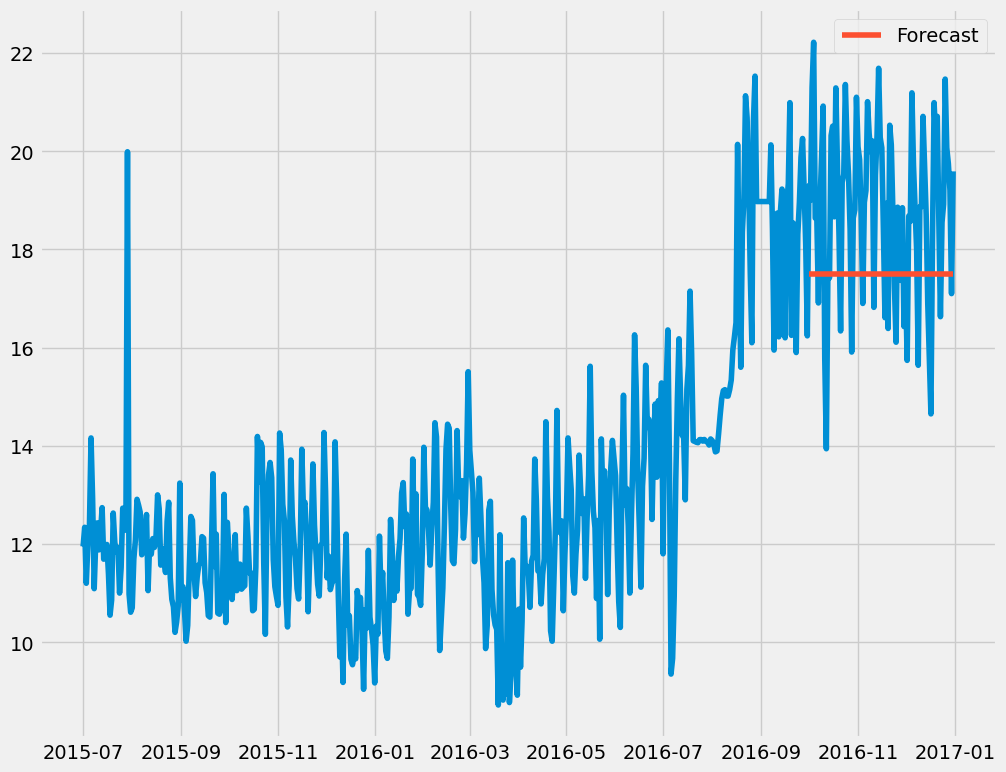

In [58]:
exp_smoothing_forecast = exp_smoothing_result.forecast(test.shape[0])

plt.plot(top_page_df)
plt.plot(exp_smoothing_forecast, label='Forecast')
plt.legend(loc='best')
plt.show()

In [59]:
rmse_values.append(('Exponential Smoothing',np.sqrt(np.mean(np.square(exp_smoothing_forecast.values - test.Views.values)))))

### Root Mean Squared Error

In [60]:
rmse_df = pd.DataFrame(rmse_values,columns=['Model','RMSE_values']).sort_values('RMSE_values')
rmse_df

,Model,RMSE_values
1,ARIMA,1.433637
0,ARMA,1.449077
2,Exponential Smoothing,2.166606
